In [63]:
from __future__ import division
import numpy as np
from sklearn.metrics import roc_curve, auc
import pandas as pd
import sys
from sys import argv
import re
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from matplotlib import style
style.use('fivethirtyeight')

In [28]:
def open_bow_df(bow_name):
    
    bow_df_file = pd.read_csv(bow_name, sep = "\t")
    
    return bow_df_file

In [29]:
def texts_to_words( raw_text ):
	# Function to convert a raw text to a string of words
	# The input is a single string (a raw text), and 
	# the output is a single string (a preprocessed text)
	#
	# 2. Remove non-letters        
	letters_only = re.sub("[^a-zA-Z0-9]", " ", raw_text) 
	#
	# 3. Convert to lower case, split into individual words
	words = letters_only.lower().split()                             
	#
	# 4. In Python, searching a set is much faster than searching
	#   a list, so convert the stop words to a set
	stops = set(stopwords.words("english"))                  
	# 
	# 5. Remove stop words
	meaningful_words = [w for w in words if not w in stops]   
	#
	# 6. Join the words back into one string separated by space, 
	# and return the result.
	return( " ".join( meaningful_words ))

In [30]:
def split_train_test(bow_df):

    data = bow_df[["Real_ID_x", "Real_ID_y", "Text"]]
    labels = bow_df["Mode"]

    test_s = 0.3 #input("What is the size of test? (0-1, float): ")
    ran_state = 1993 #input("Set random state (int): ")

    data_train, data_test, labels_train, labels_test = train_test_split(data, labels, test_size=test_s, random_state=ran_state)
    data_train, data_test, labels_train, labels_test = data_train.reset_index(drop=True), data_test.reset_index(drop=True), labels_train.reset_index(drop=True), labels_test.reset_index(drop=True) 

    return data_train, data_test, labels_train, labels_test

In [31]:
def bag_of_words_clean(bow_df):

    data_train, data_test, labels_train, labels_test = split_train_test(bow_df)
    
    # Get the number of reviews based on the dataframe column size
    num_texts = data_train["Text"].size

    # Initialize an empty list to hold the clean reviews
    print "Cleaning and parsing the training set article sentences...\n"
    clean_train_texts = []
    for i in xrange( 0, num_texts ):
        # If the index is evenly divisible by 1000, print a message
        # if( (i+1)%100 == 0 ):
            # print "Texts %d of %d\n" % ( i+1, num_texts )                                                                    
        clean_train_texts.append( texts_to_words( data_train["Text"][i] ))

    num_texts = len(data_test["Text"])
    clean_test_texts = [] 

    print "Cleaning and parsing the test set movie reviews...\n"
    for i in xrange(0,num_texts):
        # if( (i+1) % 1000 == 0 ):
            # print "Review %d of %d\n" % (i+1, num_texts)
        clean_texts = texts_to_words( data_test["Text"][i] )
        clean_test_texts.append( clean_texts )

    return clean_train_texts, clean_test_texts, labels_train, labels_test

In [32]:
bag_of_words_df = open_bow_df("./Results/Bag_of_Words_df.tsv")
clean_train, clean_test, labels_train, labels_test = bag_of_words_clean(bag_of_words_df)

Cleaning and parsing the training set article sentences...

Cleaning and parsing the test set movie reviews...



In [33]:
def vectorize_and_transform(c_train, c_test, Param_list, feature_count):
    print "Creating the bag of words...\n"
    # Initialize the "CountVectorizer" object, which is scikit-learn's
    # bag of words tool.  
    vectorizer = CountVectorizer(analyzer = "word", ngram_range=(Param_list[0], Param_list[1]), token_pattern=r'\b\w+\b', tokenizer = None, preprocessor = None, stop_words = None, max_features = feature_count) 

    # fit_transform() does two functions: First, it fits the model
    # and learns the vocabulary; second, it transforms our training data
    # into feature vectors. The input to fit_transform should be a list of 
    # strings.
    train_data_features = vectorizer.fit_transform(c_train)

    # Numpy arrays are easy to work with, so convert the result to an 
    # array
    train_data_features = train_data_features.toarray()
    
    test_data_features = vectorizer.transform(c_test)
    test_data_features = test_data_features.toarray()
    # If True then fit_transform to tfidf training data features 
    # and transform test data features to tfidf
    if Param_list[2]:
        print "Doing Tfidf transformation...\n"
        transformer = TfidfTransformer(smooth_idf=False)
        tfidf_train = transformer.fit_transform(train_data_features)
        tfidf_test = transformer.transform(test_data_features)
        tfidf_train = tfidf_train.toarray()
        tfidf_test = tfidf_test.toarray()
        print "Done!"
        return tfidf_train, tfidf_test
    print "Done!"
    return train_data_features, test_data_features

In [34]:
train_log_reg, test_log_reg = vectorize_and_transform(clean_train, clean_test, [1,1,True], 10000)

Creating the bag of words...

Doing Tfidf transformation...

Done!


In [35]:
train_ran_for, test_ran_for = vectorize_and_transform(clean_train, clean_test, [1,3,False], 1000)

Creating the bag of words...

Done!


In [38]:
rf_classifier = RandomForestClassifier(n_estimators = 100, random_state = 23)
lr_classifier = LogisticRegression()

In [40]:
lr_y_pred = lr_classifier.fit(train_log_reg, labels_train).predict_proba(test_log_reg)[:,1]
rf_y_pred = rf_classifier.fit(train_ran_for, labels_train).predict_proba(test_ran_for)[:,1]

In [48]:
fpr_lr, tpr_lr,_ = roc_curve(labels_test, lr_y_pred)
fpr_rf, tpr_rf,_ = roc_curve(labels_test, rf_y_pred)

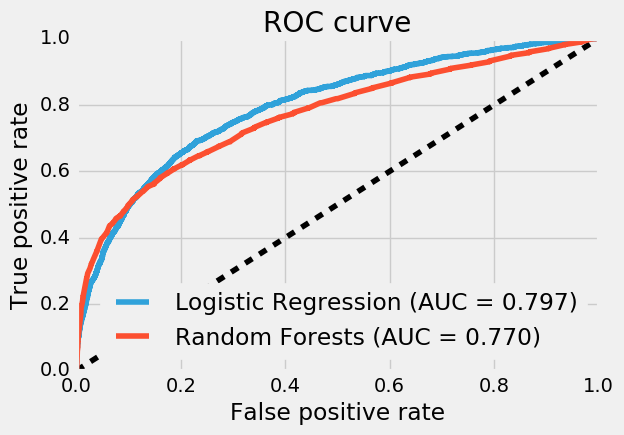

In [62]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lr, tpr_lr, label='Logistic Regression (AUC = ' + '%.3f)'% (roc_auc_lr))
plt.plot(fpr_rf, tpr_rf, label='Random Forests (AUC = ' + '%.3f)'% (roc_auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [51]:
roc_auc_lr = auc(fpr_lr, tpr_lr)

In [53]:
roc_auc_rf = auc(fpr_rf, tpr_rf)

0.77028541737217493